In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os.path
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
#current_dir = '/home/jakobkallestad'
#current_dir = '/home/jupyter'
current_dir = r'C:\Users\eirik\Documents\INF368\Exercise1'
fine_tuned_checkpoint_path = current_dir + '/best_models_cifar10/cifar10_fine_tuned_best.hdf5'
test_dir = current_dir + '/cifar10data/test/'
batch_size = 32
#input_shape = (299, 299)

In [3]:
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  #target_size=input_shape,
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  shuffle=False)

Found 10000 images belonging to 10 classes.


In [4]:
steps_test = ceil(generator_test.n / batch_size)
cls_test = generator_test.classes
class_names = list(generator_test.class_indices.keys())
num_classes = generator_test.num_classes

In [5]:
# https://keras.io/applications/#inceptionv3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print("loaded top layer checkpoint: {}".format(fine_tuned_checkpoint_path))

loaded top layer checkpoint: C:\Users\eirik\Documents\INF368\Exercise1/best_models_cifar10/cifar10_fine_tuned_best.hdf5


In [6]:
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['categorical_accuracy']) #, top_5_accuracy])

In [7]:
result = model.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

313/313 [==============================] - 915s 3s/step - loss: 0.2126 - categorical_accuracy: 0.9542
Test-set classification accuracy: 95.42%


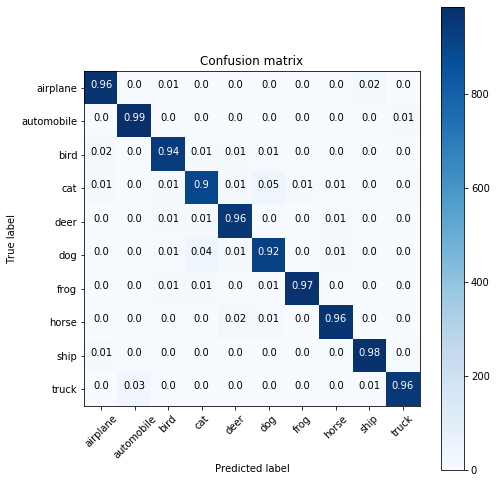

In [9]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("final_plankton_cm", format='png')
    plt.show()

test_pred_raw = model.predict(generator_test, steps=steps_test)
test_pred = np.argmax(test_pred_raw, axis=1)
cm = confusion_matrix(cls_test, test_pred)
plot_confusion_matrix(cm, class_names=class_names)